In [111]:
#Loading libraries
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib
from matplotlib import pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import (AdaBoostClassifier, VotingClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

SEED = 0
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')


In [112]:
#Ensembling approach borrowed from Anisotropic

In [113]:
#1 Loading data
df_train = pd.read_csv('./titanic/train.csv')
#Target variable
y_target = df_train[['PassengerId','Survived']]
#Note: need to drop the target variable in order to concatenate the train/test sets
df_train = df_train.drop(columns=['Survived'], axis=1)

df_test = pd.read_csv('./titanic/test.csv')

#Combining the sets for consistent label encoding
df_combined = pd.concat([df_train, df_test])
df_combined.reset_index(inplace=True, drop=True)
print('Training set size: {}'.format(df_train.shape[0]))
df_combined.head()

Training set size: 891


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


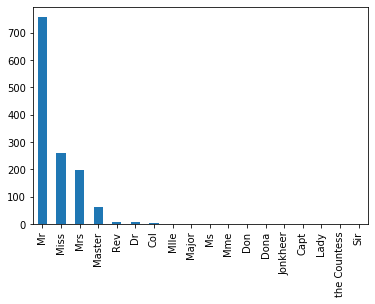

In [114]:
#2 Analysis
#How many entries are missing in a column? (df_combined.Column.isna().sum())
#Age: 263, Fare: 1, Embarked: 2
df_combined.Age = df_combined.Age.fillna(df_combined.Age.mean())
df_combined.Fare = df_combined.Fare.fillna(df_combined.Fare.mean())
df_combined.Embarked = df_combined.Embarked.fillna(df_combined.Embarked.mode().iloc[0])
#Cleaning data

#Borrowed from: https://www.kaggle.com/manuelatadvice/feature-engineering-titles
def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'

# A list with the all the different titles
titles = sorted(set([x for x in df_combined.Name.map(lambda x: get_title(x))]))

# Normalize the titles, returning 'Mr', 'Master', 'Miss' or 'Mrs'
def replace_titles(x):
    title = x['Title']
    if title in ['Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Rev', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Lady','Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

# Lets create a new column for the titles
df_combined['Title'] = df_combined['Name'].map(lambda x: get_title(x))
df_combined.Title.value_counts().plot(kind='bar')

# And replace the titles, so the are normalized to 'Mr', 'Miss' and 'Mrs'
df_combined['Title'] = df_combined.apply(replace_titles, axis=1)

#Dropping unnecessary columns
df_combined.drop(['Name','Ticket','Cabin'], axis = 1,inplace=True)


In [115]:
#3 Data Prep
di_sex = {'male':0, 'female':1}
di_embarked = {'S':0,'C':1, 'Q':2}
di_title = {'Mr':0,'Mrs':1,'Miss':2, 'Master':3}

def fare_mapping(x):
    if x <= 7.91:
        x_mapped = 0
    elif x > 7.91 and x <= 14.454:
        x_mapped = 1
    elif x > 14.454 and x <= 31:
        x_mapped = 2
    elif x > 31:
        x_mapped = 3
    return int(x_mapped)

def age_mapping(x):
    if x <= 16:
        x_mapped = 0
    elif x > 16 and x <= 32:
        x_mapped = 1
    elif x > 32 and x <= 48:
        x_mapped = 2
    elif x > 48 and x <= 64:
        x_mapped = 3
    elif x > 64:
        x_mapped = 4
    return int(x_mapped)

df_combined['Sex'], df_combined['Embarked'], df_combined['Title']  = df_combined['Sex'].map(di_sex), df_combined['Embarked'].map(di_embarked), df_combined['Title'].map(di_title)
df_combined['Age'] = df_combined['Age'].apply(age_mapping)
df_combined['Fare'] = df_combined['Fare'].apply(fare_mapping)
df_combined['FamilySize'] = df_combined['SibSp'] + df_combined['Parch'] 
# df_combined['IsAlone'] = df_combined['FamilySize'].apply(lambda x: 1 if x == 0 else 0)

In [116]:
df_combined.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize
0,1,3,0,1,1,0,0,0,0,1
1,2,1,1,2,1,0,3,1,1,1
2,3,3,1,1,0,0,1,0,2,0
3,4,1,1,2,1,0,3,0,1,1
4,5,3,0,2,0,0,1,0,0,0


In [117]:
# ohe_features = ['PassengerId', 'Sex', 'Embarked','Title']
# df_combined_ohe = pd.get_dummies(df_combined[ohe_features])
# df_combined.drop(['Sex','Embarked','Title'], axis=1, inplace=True)
# df_combined = pd.merge(df_combined,df_combined_ohe, on='PassengerId', how='inner')

In [118]:
print(df_combined.shape)
df_combined.head()

(1309, 10)


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize
0,1,3,0,1,1,0,0,0,0,1
1,2,1,1,2,1,0,3,1,1,1
2,3,3,1,1,0,0,1,0,2,0
3,4,1,1,2,1,0,3,0,1,1
4,5,3,0,2,0,0,1,0,0,0


In [119]:
#Final data split for training and testing
df_train = pd.merge(df_combined, y_target, on='PassengerId', how='inner')
df_test = pd.merge(df_combined, df_test['PassengerId'], on='PassengerId', how='inner')

In [120]:
df_train.corr().loc['Survived']

PassengerId   -0.005007
Pclass        -0.338481
Sex            0.543351
Age           -0.043800
SibSp         -0.035322
Parch          0.081629
Fare           0.295875
Embarked       0.106811
Title          0.473785
FamilySize     0.016639
Survived       1.000000
Name: Survived, dtype: float64

In [121]:
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize
0,892,3,0,2,0,0,0,2,0,0
1,893,3,1,2,1,0,0,0,1,1
2,894,2,0,3,0,0,1,2,0,0
3,895,3,0,1,0,0,1,0,0,0
4,896,3,1,1,1,1,1,0,1,2


In [122]:
X = df_train.drop(['PassengerId','Survived','SibSp'],axis=1)
y_train = y_target['Survived']

X_test = df_test.drop(['PassengerId','SibSp'],axis=1)

In [123]:
kfold = KFold(n_splits=5, random_state=SEED)
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
NFOLDS = 5 # set folds for out-of-fold prediction

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [124]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kfold.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [125]:
# Put in our parameters for said classifiers
lr_params = {'penalty':'l2'}
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

# Support Vector Classifier parameters 
svc_params = {
    'C' : 0.03
    }

In [126]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

lr = SklearnHelper(clf=LogisticRegression, seed = SEED, params = lr_params)

In [127]:
X.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Title,FamilySize
0,3,0,1,0,0,0,0,1
1,1,1,2,0,3,1,1,1
2,3,1,1,0,1,0,2,0
3,1,1,2,0,3,0,1,1
4,3,0,2,0,1,0,0,0


In [128]:
X_test.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Title,FamilySize
0,3,0,2,0,0,2,0,0
1,3,1,2,0,0,0,1,1
2,2,0,3,0,1,2,0,0
3,3,0,1,0,1,0,0,0
4,3,1,1,1,1,0,1,2


In [129]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = y_train.ravel()

x_train = X.values # Creates an array of the train data
x_test = X_test.values # Creats an array of the test data

In [130]:
# nb_oof_train, nb_oof_test = get_oof(nb, x_train, y_train, x_test) # NB
lr_oof_train, lr_oof_test = get_oof(lr, x_train, y_train, x_test) # Logistic Regression

et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


In [131]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel(),
    'LogisticRegression': lr_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost,LogisticRegression
0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0,1.0
3,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0


In [132]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train, lr_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test, lr_oof_test), axis=1)

In [133]:
gbm = xgb.XGBClassifier(
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
y_pred = gbm.predict(x_test)

df_predictions = df_test[['PassengerId']]
df_predictions['Survived'] = y_pred.tolist()
df_predictions.to_csv('submission_predictions.csv',index=False)